In [1]:
# --------------------------------------------------------
# Pytorch multi-GPU Faster R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Jiasen Lu, Jianwei Yang, based on code from Ross Girshick
# --------------------------------------------------------
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
import sys
import numpy as np
import numpy.random as npr
import argparse
import pprint
import pdb
import time
import random

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data.sampler import Sampler
from torch.utils.data.sampler import BatchSampler

from roi_data_layer.roidb_VID import combined_roidb_VID
from roi_data_layer.roibatchLoader_VID import roibatchLoader_VID
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.utils.net_utils import weights_normal_init, save_net, load_net, \
      adjust_learning_rate, save_checkpoint, clip_gradient

#from model.faster_rcnn.vgg16 import vgg16
#from model.faster_rcnn.resnet import resnet
#from model.faster_rcnn.faster_rcnn import _fasterRCNN
from model.siamese_net.siameseRCNN import _siameseRCNN
from easydict import EasyDict

torch.cuda.set_device(0)
def parse_args():
    """
    Parse input arguments
    """
    args = EasyDict()
    args['dataset'] = 'imagenetVID_1_vid'
    args['net'] = 'res101'
    args['start_epoch'] = 1
    args['max_epochs'] = 1
    args['disp_interval'] = 1
    args['checkpoint_interval'] = 10000
    args['save_dir'] = 'models'
    args['num_workers'] = 1
    args['cuda'] = True
    args['large_scale'] = False
    args['mGPUs'] = False
    args['batch_size'] = 2
    args['vid_size'] = 1
    args['class_agnostic'] = False
    args['optimizer'] = 'sgd'
    args['lr'] = 0.001
    args['lr_decay_step'] = 5
    args['lr_decay_gamma'] = 0.1
    args['session'] = 1
    args['resume'] = True
    args['checksession'] = 1
    args['checkepoch'] = 8
    args['checkpoint'] = 27452
    args['cfg_file'] = 'cfgs/res101_lighthead_siam.yml'
    args['no_save'] = True
    args['ckpt'] = ''
    args['det_ckpt'] = '1_8_27452'

    return args

class batchSampler(BatchSampler):
    def __init__(self, sampler, batch_size):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if batch_size <= 0:
            raise ValueError("batch_size should be a positive integeral value, "
                             "but got batch_size={}".format(batch_size))
        self.sampler = sampler
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)  # Difference: batch.append(int(idx))
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return len(self.sampler) / self.batch_size

class sampler_imagenet_VID_sequential(Sampler):
    def __init__(self, train_size, lmdb, batch_size, vid_per_cat = 50, sample_gap_upper_bound = 2):
        '''
        This sampler samples batches from 1 video every time.
        :param train_size: the iteration per epoch.
        :param lmdb: the input lmdb.
        :param batch_size: number of video pairs for training.
        :param vid_per_cat: sampled video number for each category. Default 50.
        :param sample_gap_upper_bound: sample_gap_upper_bound is the maximum index gap to sample two images.
        '''
        assert train_size%batch_size==0, 'train_size should be divided by batch_size.'
        self._index_gap_upper_bound = sample_gap_upper_bound/lmdb._gap
        structured_indexes = lmdb._structured_indexes
        counter = 0
        samples = []

        # First, we sample the videos from each category.
        cat_idxs = list(range(30))
        sampled_vids_for_each_category = []
        for cat_idx in cat_idxs:
            vids = structured_indexes[cat_idx]
            if len(vids)>0:
                sampled_vids = vids
                sampled_vids_for_each_category.append(sampled_vids)
            else:
                sampled_vids_for_each_category.append([])
        # Next, we generate training sample indexes.
        cat_idxs = list(range(30))
        for cat_idx in cat_idxs:
            vids = sampled_vids_for_each_category[cat_idx]
            if len(vids)>0:
                # we only have 1 vid.
                vid = vids[0]
                for img_idx in range(len(vid)):
                    if img_idx==0:
                        samples.append((vid[img_idx],vid[img_idx]))
                    else:
                        samples.append((vid[img_idx-1],vid[img_idx]))
        self.samples = samples
    def __iter__(self):
        return iter(self.samples)

    def __len__(self):
        return len(self.samples)

class sampler_imagenet_VID(Sampler):
    def __init__(self, train_size, lmdb, batch_size, vid_per_cat = 50, sample_gap_upper_bound = 10):
        '''
        This sampler samples batches from 1 video every time.
        :param train_size: the iteration per epoch.
        :param lmdb: the input lmdb.
        :param batch_size: number of video pairs for training.
        :param vid_per_cat: sampled video number for each category. Default 50.
        :param sample_gap_upper_bound: sample_gap_upper_bound is the maximum index gap to sample two images.
        '''
        assert train_size%batch_size==0, 'train_size should be divided by batch_size.'
        self._index_gap_upper_bound = int(sample_gap_upper_bound/lmdb._gap)
        structured_indexes = lmdb._structured_indexes
        counter = 0
        samples = []
        while counter<train_size:
            # First, we sample the videos from each category.
            cat_idxs = list(range(30))
            sampled_vids_for_each_category = []
            for cat_idx in cat_idxs:
                vids = structured_indexes[cat_idx]
                if len(vids)>0:
                    sampled_vids = random.sample(vids, vid_per_cat)
                    sampled_vids_for_each_category.append(sampled_vids)
                else:
                    sampled_vids_for_each_category.append([])
            # Next, we generate training sample indexes.
            for vid_id in range(vid_per_cat):
                cat_idxs = list(range(30))
                random.shuffle(cat_idxs)
                for cat_idx in cat_idxs:
                    vids = sampled_vids_for_each_category[cat_idx]
                    if len(vids)>0:
                        vid = vids[vid_id]
                        for _ in range(batch_size):
                            item = random.sample(vid[:-self._index_gap_upper_bound], 1)
                            item = (item[0], item[0]+self._index_gap_upper_bound)
                            samples.append(item)
                            counter+=1
        self.samples = samples[:train_size]

    def __iter__(self):
        return iter(self.samples)

    def __len__(self):
        return len(self.samples)

def create_tensor_holder():
    # initilize the tensor holder here.
    im_data = torch.FloatTensor(1)
    im_info = torch.FloatTensor(1)
    num_boxes = torch.LongTensor(1)
    gt_boxes = torch.FloatTensor(1)

    # ship to cuda
    if args.cuda:
        im_data = im_data.cuda()
        im_info = im_info.cuda()
        num_boxes = num_boxes.cuda()
        gt_boxes = gt_boxes.cuda()

    # make variable
    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)
    return im_data,im_info,num_boxes,gt_boxes

def get_CNN_params(model, lr):
    params = []
    for key, value in dict(model.named_parameters()).items():
        if value.requires_grad:
            if 'bias' in key:
                params += [{'params': [value], 'lr': lr * (cfg.TRAIN.DOUBLE_BIAS + 1),
                            'weight_decay': cfg.TRAIN.BIAS_DECAY and cfg.TRAIN.WEIGHT_DECAY or 0}]
            else:
                params += [{'params': [value], 'lr': lr, 'weight_decay': cfg.TRAIN.WEIGHT_DECAY}]
    return params

import cPickle
import cPickle
import cPickle


In [2]:
args = parse_args()

print('Called with args:')
print(args)

if args.dataset == "imagenet":
    args.imdb_name = "imagenet_train"
    args.imdbval_name = "imagenet_val"
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenet_10_imgs":
    args.imdb_name = "imagenet_10_imgs_train"
    args.imdbval_name = "imagenet_10_imgs_val"
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenetVID_1_vid":
    args.imdb_name = 'imagenetVID_1_vid_train'
    args.imdbval_name = 'imagenetVID_1_vid_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == "imagenetVID":
    args.imdb_name = 'imagenetVID_train'
    args.imdbval_name = 'imagenetVID_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']
elif args.dataset == 'imagenetDETVID':
    args.imdb_name = 'imagenetDETVID_train'
    args.imdbval_name = 'imagenetDETVID_val'
    args.set_cfgs = ['ANCHOR_SCALES', '[4, 8, 16, 32]', 'ANCHOR_RATIOS', '[0.5,1,2]', 'MAX_NUM_GT_BOXES', '30']

if args.cfg_file is None:
    args.cfg_file = "cfgs/{}_ls.yml".format(args.net) if args.large_scale else "cfgs/{}.yml".format(args.net)

if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)
if args.set_cfgs is not None:
    cfg_from_list(args.set_cfgs)

print('Using config:')
pprint.pprint(cfg)
np.random.seed(cfg.RNG_SEED)


Called with args:
{'checksession': 1, 'cfg_file': 'cfgs/res101_lighthead_siam.yml', 'start_epoch': 1, 'dataset': 'imagenetVID_1_vid', 'ckpt': '', 'session': 1, 'max_epochs': 1, 'det_ckpt': '1_8_27452', 'mGPUs': False, 'disp_interval': 1, 'resume': True, 'checkpoint': 27452, 'lr': 0.001, 'net': 'res101', 'cuda': True, 'optimizer': 'sgd', 'num_workers': 1, 'batch_size': 2, 'checkepoch': 8, 'lr_decay_step': 5, 'vid_size': 1, 'no_save': True, 'large_scale': False, 'lr_decay_gamma': 0.1, 'save_dir': 'models', 'checkpoint_interval': 10000, 'class_agnostic': False}
Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': False,
 'DATA_DIR': '/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'res101',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 30,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_

lib/model/utils/config.py:469: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


### Training

In [3]:
#torch.backends.cudnn.benchmark = True
if torch.cuda.is_available() and not args.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

# train set
# -- Note: Use validation set and disable the flipped to enable faster loading.
cfg.TRAIN.USE_FLIPPED = False
cfg.USE_GPU_NMS = args.cuda
# TODO change combined_roidb.
imdb, roidb, ratio_list, ratio_index = combined_roidb_VID(args.imdb_name)

print('{:d} roidb entries'.format(len(roidb)))

output_dir = args.save_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# TODO change the dataloader and sampler.
train_size = 150
my_sampler = sampler_imagenet_VID(
    train_size = train_size, 
    lmdb=imdb, 
    batch_size=args.batch_size, 
    vid_per_cat = 1, 
    sample_gap_upper_bound = 2)
my_batch_sampler = batchSampler(sampler = my_sampler, batch_size=args.batch_size)

dataset = roibatchLoader_VID(roidb, ratio_list, ratio_index, args.batch_size, imdb.num_classes, training=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=my_batch_sampler, num_workers=args.num_workers)

if args.cuda:
    cfg.CUDA = True

Loaded dataset `imagenetVID_1_vid_train` for training
Set proposal method: gt
Preparing training data...
/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_1_vid_train_gt_roidb.pkl
wrote gt roidb to /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_1_vid_train_gt_roidb.pkl
Image sizes loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_1_vid_train_sizes.pkl
20
20
done
20 roidb entries


In [4]:
# initilize the network here.
if args.net == 'res101':
      RCNN = _siameseRCNN(imdb.classes, args)
else:
    print("network is not defined")
    pdb.set_trace()

lr = cfg.TRAIN.LEARNING_RATE
lr = args.lr
#tr_momentum = cfg.TRAIN.MOMENTUM
#tr_momentum = args.momentum

params = []
params = get_CNN_params(RCNN, lr)

if args.optimizer == "adam":
    lr = lr * 0.1
    optimizer = torch.optim.Adam(params)

elif args.optimizer == "sgd":
    optimizer = torch.optim.SGD(params, momentum=cfg.TRAIN.MOMENTUM)

assert args.cuda, 'Only cuda version is supported.'
RCNN.cuda()

assert not (args.ckpt is not '' and args.det_ckpt is not '')
if args.ckpt is not '':
    load_name_predix = cfg.RESNET.CORE_CHOICE.USE+'_siam'
    # TODO add OHEM later.
    if cfg.TRAIN.OHEM is True:
        load_name_predix = load_name_predix + '_OHEM'
    load_name = os.path.join(output_dir, load_name_predix + '_{}.pth'.format(args.ckpt))
    print("loading checkpoint %s" % (load_name))
    checkpoint = torch.load(load_name)
    args.session = checkpoint['session']
    #TODO
    #args.start_epoch = checkpoint['epoch']
    RCNN.load_state_dict(checkpoint['model'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    print("loaded checkpoint %s" % (load_name))
    
if args.det_ckpt is not '':
    load_name_predix = cfg.RESNET.CORE_CHOICE.USE
    load_name = os.path.join(output_dir, load_name_predix + '_{}.pth'.format(args.det_ckpt)).replace('VID_1_vid','DETVID')
    print("loading checkpoint %s" % (load_name))
    checkpoint = torch.load(load_name)
    args.session = checkpoint['session']
    #TODO
    #args.start_epoch = checkpoint['epoch']
    RCNN.RCNN.load_state_dict(checkpoint['model'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    print("loaded checkpoint %s" % (load_name))

if args.mGPUs:
    RCNN = nn.DataParallel(RCNN)

iters_per_epoch = int(train_size / args.batch_size)

im_data_1, im_info_1, num_boxes_1, gt_boxes_1 = create_tensor_holder()
im_data_2, im_info_2, num_boxes_2, gt_boxes_2 = create_tensor_holder()

RCNN uses RFCN Light Head core.
Loading pretrained weights from data/pretrained_model/resnet101_caffe.pth
loading checkpoint models/res101/imagenetDETVID/rfcn_light_head_1_8_27452.pth
loaded checkpoint models/res101/imagenetDETVID/rfcn_light_head_1_8_27452.pth


#### Start training.

In [5]:
max_epoch = 2
for epoch in range(max_epoch):
    data_iter = iter(dataloader)
    loss_temp = 0
    start = time.time()
    for step in range(iters_per_epoch):
        data_1, data_2 = next(data_iter)

        im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
        im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
        gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
        num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

        im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
        im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
        gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
        num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])
        
        #print(im_data.shape)
        RCNN.zero_grad()
        input = (im_data_1, im_info_1, num_boxes_1, gt_boxes_1, im_data_2, im_info_2, num_boxes_2, gt_boxes_2)
        rois_label, siamRPN_loss_cls, siamRPN_loss_box, rpn_loss_cls, rpn_loss_box, RCNN_loss_cls, RCNN_loss_bbox = RCNN(input)

        loss = rpn_loss_cls.mean() + rpn_loss_box.mean() \
             + RCNN_loss_cls.mean() + RCNN_loss_bbox.mean()\
             + siamRPN_loss_cls.mean() + siamRPN_loss_box.mean()
        loss_temp += loss.item()

        # backward
        optimizer.zero_grad()
        loss.backward()
        clip_gradient(RCNN.siameseRPN_layer, 10.)
        optimizer.step()

        if step % args.disp_interval == 0:
            end = time.time()
        if step > 0:
            loss_temp /= (args.disp_interval + 1)

        if args.mGPUs:
            loss_siam_cls = siamRPN_loss_cls.mean().item()
            loss_siam_box = siamRPN_loss_box.mean().item()
            loss_rpn_cls = rpn_loss_cls.mean().item()
            loss_rpn_box = rpn_loss_box.mean().item()
            loss_rcnn_cls = RCNN_loss_cls.mean().item()
            loss_rcnn_box = RCNN_loss_bbox.mean().item()
        else:
            loss_siam_cls = siamRPN_loss_cls.item()
            loss_siam_box = siamRPN_loss_box.item()
            loss_rpn_cls = rpn_loss_cls.item()
            loss_rpn_box = rpn_loss_box.item()
            loss_rcnn_cls = RCNN_loss_cls.item()
            loss_rcnn_box = RCNN_loss_bbox.item()

        fg_cnt = torch.sum(rois_label.data.ne(0))
        bg_cnt = rois_label.data.numel() - fg_cnt

        print("[session %d][epoch %2d][iter %4d/%4d] loss: %.4f, lr: %.2e" \
                                % (args.session, epoch, step, iters_per_epoch, loss_temp, lr))
        print("\t\t\tfg/bg=(%d/%d), time cost: %f" % (fg_cnt, bg_cnt, end-start))
        print("\t\t\trpn_cls: %.4f, rpn_box: %.4f, rcnn_cls: %.4f, rcnn_box %.4f" \
                      % (loss_rpn_cls, loss_rpn_box, loss_rcnn_cls, loss_rcnn_box))
        print("\t\t\tsiam_rpn_cls: %.4f, siam_rpn_box: %.4f" \
              % (loss_siam_cls, loss_siam_box))
        loss_temp = 0
        start = time.time()
        

[session 1][epoch  0][iter    0/  75] loss: 3.7137, lr: 1.00e-03
			fg/bg=(105/407), time cost: 2.406823
			rpn_cls: 0.2242, rpn_box: 0.0220, rcnn_cls: 2.1580, rcnn_box 0.6071
			siam_rpn_cls: 0.6955, siam_rpn_box: 0.0069
[session 1][epoch  0][iter    1/  75] loss: 1.2504, lr: 1.00e-03
			fg/bg=(105/407), time cost: 1.467214
			rpn_cls: 0.2417, rpn_box: 0.0195, rcnn_cls: 1.0265, rcnn_box 0.5153
			siam_rpn_cls: 0.6909, siam_rpn_box: 0.0067
[session 1][epoch  0][iter    2/  75] loss: 0.8255, lr: 1.00e-03
			fg/bg=(126/386), time cost: 1.398698
			rpn_cls: 0.1506, rpn_box: 0.0117, rcnn_cls: 0.3565, rcnn_box 0.4439
			siam_rpn_cls: 0.6805, siam_rpn_box: 0.0077
[session 1][epoch  0][iter    3/  75] loss: 0.7104, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.444238
			rpn_cls: 0.1231, rpn_box: 0.0119, rcnn_cls: 0.3220, rcnn_box 0.2864
			siam_rpn_cls: 0.6683, siam_rpn_box: 0.0091
[session 1][epoch  0][iter    4/  75] loss: 0.8208, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.483880
			rpn_

[session 1][epoch  0][iter   37/  75] loss: 0.2052, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.595257
			rpn_cls: 0.0018, rpn_box: 0.0029, rcnn_cls: 0.1504, rcnn_box 0.2090
			siam_rpn_cls: 0.0410, siam_rpn_box: 0.0054
[session 1][epoch  0][iter   38/  75] loss: 0.2851, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.573855
			rpn_cls: 0.0093, rpn_box: 0.0116, rcnn_cls: 0.1204, rcnn_box 0.4119
			siam_rpn_cls: 0.0137, siam_rpn_box: 0.0034
[session 1][epoch  0][iter   39/  75] loss: 0.2116, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.692491
			rpn_cls: 0.0044, rpn_box: 0.0052, rcnn_cls: 0.1092, rcnn_box 0.2919
			siam_rpn_cls: 0.0098, siam_rpn_box: 0.0027
[session 1][epoch  0][iter   40/  75] loss: 0.2754, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.661763
			rpn_cls: 0.0064, rpn_box: 0.0076, rcnn_cls: 0.1085, rcnn_box 0.4142
			siam_rpn_cls: 0.0108, siam_rpn_box: 0.0033
[session 1][epoch  0][iter   41/  75] loss: 0.1518, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.592342
			rpn_

[session 1][epoch  0][iter   74/  75] loss: 0.1932, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.616419
			rpn_cls: 0.0016, rpn_box: 0.0032, rcnn_cls: 0.1002, rcnn_box 0.2636
			siam_rpn_cls: 0.0154, siam_rpn_box: 0.0024
[session 1][epoch  1][iter    0/  75] loss: 0.3439, lr: 1.00e-03
			fg/bg=(128/384), time cost: 2.027979
			rpn_cls: 0.0057, rpn_box: 0.0117, rcnn_cls: 0.0803, rcnn_box 0.2353
			siam_rpn_cls: 0.0085, siam_rpn_box: 0.0024
[session 1][epoch  1][iter    1/  75] loss: 0.1520, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.560761
			rpn_cls: 0.0024, rpn_box: 0.0119, rcnn_cls: 0.0671, rcnn_box 0.2122
			siam_rpn_cls: 0.0086, siam_rpn_box: 0.0020
[session 1][epoch  1][iter    2/  75] loss: 0.1369, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.570224
			rpn_cls: 0.0020, rpn_box: 0.0084, rcnn_cls: 0.0934, rcnn_box 0.1596
			siam_rpn_cls: 0.0086, siam_rpn_box: 0.0019
[session 1][epoch  1][iter    3/  75] loss: 0.1467, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.597802
			rpn_

[session 1][epoch  1][iter   36/  75] loss: 0.1693, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.551805
			rpn_cls: 0.0069, rpn_box: 0.0098, rcnn_cls: 0.1040, rcnn_box 0.2029
			siam_rpn_cls: 0.0127, siam_rpn_box: 0.0022
[session 1][epoch  1][iter   37/  75] loss: 0.1499, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.563819
			rpn_cls: 0.0010, rpn_box: 0.0087, rcnn_cls: 0.1056, rcnn_box 0.1734
			siam_rpn_cls: 0.0093, siam_rpn_box: 0.0019
[session 1][epoch  1][iter   38/  75] loss: 0.1296, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.562480
			rpn_cls: 0.0055, rpn_box: 0.0058, rcnn_cls: 0.0796, rcnn_box 0.1555
			siam_rpn_cls: 0.0103, siam_rpn_box: 0.0026
[session 1][epoch  1][iter   39/  75] loss: 0.1477, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.400082
			rpn_cls: 0.0028, rpn_box: 0.0073, rcnn_cls: 0.0857, rcnn_box 0.1899
			siam_rpn_cls: 0.0068, siam_rpn_box: 0.0028
[session 1][epoch  1][iter   40/  75] loss: 0.1655, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.550270
			rpn_

[session 1][epoch  1][iter   73/  75] loss: 0.1352, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.594695
			rpn_cls: 0.0070, rpn_box: 0.0038, rcnn_cls: 0.1037, rcnn_box 0.1439
			siam_rpn_cls: 0.0105, siam_rpn_box: 0.0015
[session 1][epoch  1][iter   74/  75] loss: 0.1177, lr: 1.00e-03
			fg/bg=(128/384), time cost: 1.649977
			rpn_cls: 0.0009, rpn_box: 0.0023, rcnn_cls: 0.0851, rcnn_box 0.1360
			siam_rpn_cls: 0.0095, siam_rpn_box: 0.0017


In [6]:
# save model.
name_prefix = ''
if cfg.RESNET.CORE_CHOICE.USE == cfg.RESNET.CORE_CHOICE.FASTER_RCNN:
    name_prefix = 'faster_rcnn'
elif cfg.RESNET.CORE_CHOICE.USE == cfg.RESNET.CORE_CHOICE.RFCN_LIGHTHEAD:
    name_prefix = 'rfcn_light_head'
elif cfg.RESNET.CORE_CHOICE.USE == cfg.RESNET.CORE_CHOICE.RFCN:
    name_prefix = 'rfcn'
else:
    pass
name_prefix+'_siam'
save_name = os.path.join(output_dir, name_prefix + '_{}.pth'.format('temp'))
print('save_name:',save_name)

save_name: models/res101/imagenetVID_1_vid/rfcn_light_head_temp.pth


In [7]:
save_checkpoint({
  'session': 1,
  'epoch': 1+1,
  'model': RCNN.module.state_dict() if args.mGPUs else RCNN.state_dict(),
  'optimizer': optimizer.state_dict(),
  'pooling_mode': cfg.POOLING_MODE,
  'class_agnostic': args.class_agnostic,
}, save_name)
print('save model: {}'.format(save_name))

save model: models/res101/imagenetVID_1_vid/rfcn_light_head_temp.pth


In [8]:
torch.cuda.empty_cache()

### Testing

In [9]:
from model.siamese_net.weight_cropping_layer import weight_crop_layer
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
from model.rpn.bbox_transform import bbox_transform_inv
def bbox_delta_to_pred_boxes(im_info, boxes, bbox_pred):
    box_deltas = bbox_pred.data
    if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
        # Optionally normalize targets by a precomputed mean and stdev
        if args.class_agnostic:
            box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                         + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            box_deltas = box_deltas.view(1, -1, 4)
        else:
            box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                         + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            box_deltas = box_deltas.view(1, -1, 4 * len(imdb.classes))

    pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
    pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
    return pred_boxes

weight_cropper = weight_crop_layer().cuda()
def siam_weights_preparation(rois_tracking, base_feat):
    if rois_tracking is None:
        return None, None
    else:
        rois_tracking = Variable(base_feat.new_tensor(rois_tracking))
        rois_tracking[:,:4] = rois_tracking[:,:4]
        boxes = rois_tracking[:,:4]
        batch_inds = boxes.new_zeros((boxes.size(0),1))
        boxes = torch.cat((batch_inds, boxes),dim=1)
        template_weights = weight_cropper(base_feat, boxes)
        return template_weights, rois_tracking

def prepare_rois_tracking(im_info, all_boxes, all_boxes_scores, frame_id, class_num, thresh=cfg.SIAMESE.THRESH_FOR_TRACKING):
    # class_num is 31 for imagenetVID.
    sel_boxes = []
    for j in range(1, class_num):
        if len(all_boxes[j][frame_id])==0:
            continue
        scored_boxes = all_boxes[j][frame_id].copy()
        scores = all_boxes_scores[j][frame_id].copy()
        assert len(scored_boxes)==len(scores), 'length of scored_boxes and length of scores should be the equal.'
        # TODO comment out the following for loop to accelerate predictions.
        scored_boxes[:,:4] = scored_boxes[:,:4]*im_info[-1]
        for b_id in range(len(scored_boxes)):
            assert scored_boxes[b_id, 4] == scores[b_id, j], \
            'scores not matched, please check your code.{} and {}'.format(scored_boxes[:,4], scores[:,j])
        #print('scored_boxes[:, 4]:',scored_boxes[:, 4])
        #print('thresh:',thresh)
        inds = np.where(scored_boxes[:, 4]>thresh)[0]
        if len(inds)>0:
            sel_cls_boxes = np.concatenate((scored_boxes[inds,:4], scores[inds,:]), axis=1)
            sel_boxes.append(sel_cls_boxes)
        else:
            continue
    if len(sel_boxes)>0:
        rois_tracking = np.concatenate(sel_boxes, axis=0)
    else:
        rois_tracking = None
    return rois_tracking

def show_det(im_info, im2show, all_boxes,img_id,threshold=0.7,show_class=True):
    # show on resized images.
    dpi = 120
    fig = plt.figure(frameon=False)
    fig.set_size_inches(im2show.shape[1] / dpi, im2show.shape[0] / dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.axis('off')
    fig.add_axes(ax)
    ax.imshow(im2show)
    scale = im_info[0][-1]
    for j in range(1, len(imdb.classes)):
        if isinstance(all_boxes[j][img_id], np.ndarray):
            for bbox in all_boxes[j][img_id]:
                tbox = np.copy(bbox)
                tbox[:4] = tbox[:4]*scale
                if tbox[-1]>threshold:
                    ax.add_patch(
                    plt.Rectangle((tbox[0], tbox[1]),
                              tbox[2] - tbox[0],
                              tbox[3] - tbox[1],
                              fill=False, edgecolor='y',
                              linewidth=3.0, alpha=0.4))
                    if show_class:
                        ax.text(tbox[0], tbox[1] - 2,
                        '%s %f'%(imdb.classes[j], tbox[-1]),
                        fontsize=10,
                        #family='serif',
                        bbox=dict(
                            facecolor='y', alpha=0.4, pad=0, edgecolor='none'),
                            color='white')

In [10]:
from matplotlib import pyplot as plt
import cv2

In [11]:
args.batch_size = 1
my_sampler = sampler_imagenet_VID_sequential(
    train_size = 150, 
    lmdb=imdb, 
    batch_size=args.batch_size, 
    vid_per_cat = 1, 
    sample_gap_upper_bound = 10)
my_batch_sampler = batchSampler(sampler = my_sampler, batch_size=args.batch_size)
dataset = roibatchLoader_VID(roidb, ratio_list, ratio_index, args.batch_size, imdb.num_classes, training=False)
dataloader = torch.utils.data.DataLoader(dataset, batch_sampler=my_batch_sampler, num_workers=args.num_workers)

In [12]:
# initilize the network here.
if args.net == 'res101':
    RCNN = _siameseRCNN(imdb.classes, args)
else:
    print("network is not defined")
    pdb.set_trace()
input_dir = args.save_dir + "/" + args.net + "/" + args.dataset
if not os.path.exists(input_dir):
    raise Exception('There is no input directory for loading network from ' + input_dir)

#print('cfg.RESNET.CORE_CHOICE.USE:',cfg.RESNET.CORE_CHOICE.USE)
load_name_predix = cfg.RESNET.CORE_CHOICE.USE# + '_siam'
load_name = os.path.join(input_dir, load_name_predix+'_{}.pth'.format('temp'))
print(load_name)

RCNN uses RFCN Light Head core.
Loading pretrained weights from data/pretrained_model/resnet101_caffe.pth
models/res101/imagenetVID_1_vid/rfcn_light_head_temp.pth


In [13]:
checkpoint = torch.load(load_name)
RCNN.load_state_dict(checkpoint['model'])
print('load model successfully!')

load model successfully!


In [14]:
RCNN.eval()
empty_array = np.transpose(np.array([[],[],[],[],[]]), (1,0))

In [15]:
data_iter = iter(dataloader)
torch.cuda.empty_cache()

In [16]:
start = time.time()
max_per_image = 100
vis = False
if vis:
    thresh = 0.05
else:
    thresh = 0.0
num_images = 1000
all_boxes = [[[] for _ in xrange(num_images)]
               for _ in xrange(imdb.num_classes)]
all_boxes_scores = [[[] for _ in xrange(num_images)]
                   for _ in xrange(imdb.num_classes)]

In [17]:
template_weights = None
rois_tracking = None
img = None
i=0

In [18]:
#for _ in range(200):
#    data_1, data_2 = next(data_iter)
#while True:

f_iter_gap = 1
for _ in range(f_iter_gap):
    data_1, data_2 = next(data_iter)

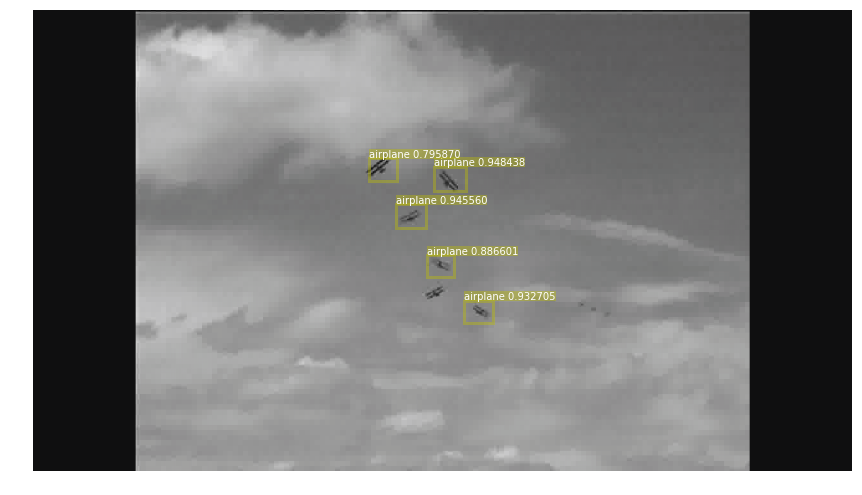

In [76]:
#f_iter_gap = 1
#for _ in range(f_iter_gap):
#    data_1, data_2 = next(data_iter)
im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])

data, im_data, im_info = data_2, im_data_2, im_info_2
input = im_data, im_info, template_weights, rois_tracking
det_tic = time.time()
siam_rois, siam_bbox_pred, siam_cls_prob, rois, rois_label, cls_prob, bbox_pred = RCNN(input)

###########################################
# Get detection boxes.
###########################################
if cfg.TEST.BBOX_REG:
    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]
    pred_boxes = bbox_delta_to_pred_boxes(im_info, boxes, bbox_pred)
    pred_boxes /= data[1][0][2].item()
    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()
    if siam_bbox_pred is not None:
        siam_scores = siam_cls_prob.data
        siam_boxes = siam_rois.data[:, 1:5]
        pred_siam_bbox = bbox_delta_to_pred_boxes(im_info, siam_boxes.unsqueeze(0), siam_bbox_pred.unsqueeze(0))
        pred_siam_bbox /= data[1][0][2].item()
        pred_siam_bbox = pred_siam_bbox.squeeze(0)
        # concatenate siambox and detbox.
        #####################
        #pred_boxes = torch.cat((pred_boxes, pred_siam_bbox), 0)
        #scores = torch.cat((scores, siam_scores), 0)
        #####################
        pred_boxes = siam_boxes.repeat(1,siam_boxes.size(1)*31)
        pred_boxes = pred_boxes/im_info[0][-1]
        #####################
        #pred_boxes = pred_siam_bbox
        #####################
        scores = siam_scores
else:
    raise ValueError('Error. Should set cfg.TEST.BBOX_REG to True.')

det_toc = time.time()
detect_time = det_toc - det_tic
misc_tic = time.time()
###########################################
# NMS for detection and save to all boxes.
###########################################
for j in xrange(1, imdb.num_classes):
    inds = torch.nonzero(scores[:,j]>thresh).view(-1)
    # if there is det
    if inds.numel() > 0:
        cls_scores = scores[:,j][inds]
        all_scores = scores[inds]
        _, order = torch.sort(cls_scores, 0, True)
        if args.class_agnostic:
            cls_boxes = pred_boxes[inds, :]
        else:
            cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

        cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
        # cls_dets = torch.cat((cls_boxes, cls_scores), 1)
        cls_dets = cls_dets[order]
        all_scores = all_scores[order]
        ######### nms for each cls here ########
        keep = nms(cls_dets, cfg.TEST.NMS)
        cls_dets = cls_dets[keep.view(-1).long()]
        all_cls_scores = all_scores[keep.view(-1).long()]
        all_boxes[j][i] = cls_dets.cpu().numpy()
        all_boxes_scores[j][i] = all_cls_scores.cpu().numpy()
    else:
        all_boxes[j][i] = empty_array
        all_boxes_scores[j][i] = empty_array

# Limit to max_per_image detections *over all classes*
if max_per_image > 0:
    image_scores = np.hstack([all_boxes[j][i][:, -1]
                                for j in xrange(1, imdb.num_classes)])
    if len(image_scores) > max_per_image:
        image_thresh = np.sort(image_scores)[-max_per_image]
        for j in xrange(1, imdb.num_classes):
            keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
            all_boxes[j][i] = all_boxes[j][i][keep, :]
            all_boxes_scores[j][i] = all_boxes_scores[j][i][keep, :]

img = ((im_data_2.squeeze().cpu().numpy()).transpose(1,2,0)+np.array([[[102.9801, 115.9465, 122.7717]]])).astype(np.uint8)
show_det(im_info, img, all_boxes,i, 0.1)

In [77]:
########
# Get weights for the next iteration.
########
# First, convert all_boxes to rois_tracking.#
rois_tracking = prepare_rois_tracking(im_info[0], all_boxes, all_boxes_scores, frame_id=i, class_num=imdb.num_classes, thresh=0.3)
base_feat = RCNN.track_feat_trans.cuda()(RCNN.RCNN.Conv_feat_track)
template_weights, rois_tracking = siam_weights_preparation(rois_tracking, base_feat)
print(rois_tracking)
misc_toc = time.time()
nms_time = misc_toc - misc_tic

sys.stdout.write('im_detect: {:d}/{:d} {:.3f}s {:.3f}s   \r' \
  .format(i + 1, num_images, detect_time, nms_time))
sys.stdout.flush()
last_img = img
i+=1

tensor([[6.6823e+02, 2.6062e+02, 7.2044e+02, 3.0071e+02, 5.1129e-02, 9.4844e-01,
         9.2434e-06, 4.2897e-06, 1.1493e-05, 1.9418e-05, 3.4684e-05, 9.2700e-05,
         9.0863e-06, 7.7041e-06, 1.5676e-05, 3.0514e-06, 6.3939e-06, 1.0192e-06,
         4.4197e-06, 8.5147e-06, 1.3863e-06, 1.7894e-05, 8.9948e-06, 1.3219e-05,
         1.8535e-06, 2.7226e-06, 1.0024e-05, 3.0302e-06, 7.3608e-06, 1.0786e-06,
         1.1798e-05, 2.8233e-06, 8.1691e-05, 2.7028e-05, 4.4127e-06],
        [6.0418e+02, 3.2304e+02, 6.5468e+02, 3.6201e+02, 5.4001e-02, 9.4556e-01,
         7.3254e-06, 2.8848e-06, 2.0526e-05, 3.1449e-05, 2.5525e-05, 4.5407e-05,
         5.9344e-06, 2.4814e-06, 1.0853e-05, 4.0594e-06, 4.2226e-06, 1.1215e-06,
         2.3731e-06, 5.3834e-06, 1.1745e-06, 1.6180e-05, 1.7870e-06, 2.0837e-05,
         1.1101e-06, 1.3956e-06, 4.6585e-06, 1.1064e-05, 5.8267e-06, 9.6597e-07,
         1.0156e-05, 3.7324e-06, 1.0093e-04, 6.3513e-05, 1.5978e-05],
        [7.1799e+02, 4.8399e+02, 7.6529e+02, 5.215

In [78]:
f_iter_gap = 1
for _ in range(f_iter_gap):
    data_1, data_2 = next(data_iter)

StopIteration: 

In [22]:
print('im_data_1:', im_data_1.shape)
print('im_info_1:', im_info_1)

im_data_1: torch.Size([1, 3, 600, 1067])
im_info_1: tensor([[ 600.0000, 1067.0000,    0.8333]], device='cuda:0')


In [68]:
print(template_weights.shape)

torch.Size([5, 1024, 3, 3])


In [ ]:
# weights
for i in range(6):
    weight = template_weights[i].cpu().numpy()
    weight = (weight.transpose(1,2,0)).astype(np.uint8)
    plt.figure(figsize=(5,5))
    plt.imshow(weight)
    plt.show()

In [ ]:
print(all_boxes[2][:2])

In [ ]:
siam_rois, siam_bbox_pred, siam_cls_prob, rois, rois_label, cls_prob, bbox_pred

In [ ]:
print(all_boxes[2][i-1])

In [ ]:
print(scores)

In [ ]:
print(template_weights)
print(rois_tracking)

In [ ]:
print(rois_tracking)
#while True:
for i in range(50):
    data_1, data_2 = next(data_iter)

im_data_1.data.resize_(data_1[0].size()).copy_(data_1[0])
im_info_1.data.resize_(data_1[1].size()).copy_(data_1[1])
gt_boxes_1.data.resize_(data_1[2].size()).copy_(data_1[2])
num_boxes_1.data.resize_(data_1[3].size()).copy_(data_1[3])

im_data_2.data.resize_(data_2[0].size()).copy_(data_2[0])
im_info_2.data.resize_(data_2[1].size()).copy_(data_2[1])
gt_boxes_2.data.resize_(data_2[2].size()).copy_(data_2[2])
num_boxes_2.data.resize_(data_2[3].size()).copy_(data_2[3])

#print(im_data.shape)
RCNN.zero_grad()
##################################
#        Detection part          #
##################################
# detection loss for image 1.
rois_1, cls_prob_1, bbox_pred_1, \
rpn_loss_cls_1, rpn_loss_box_1, \
RCNN_loss_cls_1, RCNN_loss_bbox_1, \
rois_label_1 = RCNN(im_data_1, im_info_1, gt_boxes_1, num_boxes_1)

#c3_1, c4_1, c5_1 = RCNN.c_3, RCNN.c_4, RCNN.c_5
conv4_feat_1 = RCNN.Conv4_feat
rpn_rois_1 = RCNN.rpn_rois

# detection loss for image 2.
rois_2, cls_prob_2, bbox_pred_2, \
rpn_loss_cls_2, rpn_loss_box_2, \
RCNN_loss_cls_2, RCNN_loss_bbox_2, \
rois_label_2 = RCNN(im_data_2, im_info_2, gt_boxes_2, num_boxes_2)

#c3_2, c4_2, c5_2 = RCNN.c_3, RCNN.c_4, RCNN.c_5
conv4_feat_2 = RCNN.Conv4_feat
rpn_rois_2 = RCNN.rpn_rois

##################################
#        Tracking part           #
##################################
# define tracking loss here.
tracking_losses_cls_ls = []
tracking_losses_box_ls = []

rtv_training_tuples = t_t_prop_layer(conv4_feat_1, conv4_feat_2, None, gt_boxes_1, gt_boxes_2)
assert len(rtv_training_tuples)==1
tpl_id = 0
target_feat, template_weights, target_gt_boxes = rtv_training_tuples[tpl_id]
input_v = (target_feat,
           im_info_2[tpl_id:tpl_id+1], 
           template_weights,
           target_gt_boxes, 
           1)
siam_rois, rpn_loss_cls_siam, rpn_loss_box_siam = siameseRPN_layer(input_v)
tracking_losses_cls_ls.append(rpn_loss_cls_siam)
tracking_losses_box_ls.append(rpn_loss_box_siam)
#Show
img = np.squeeze(im_data_2.cpu().numpy())
det_rpn = rpn_rois_2.cpu().numpy()
siam_rpn = siam_rois.cpu().numpy()
img = img.transpose(1,2,0)
temp_img = (img+cfg.PIXEL_MEANS).astype(np.uint8)
temp_img = np.ascontiguousarray(temp_img[:,:,(2,1,0)])

#box = det_rpn[0,0,1:5].astype(np.int32)
#t_ = temp_img.copy()
#cv2.rectangle(t_,(box[0],box[1]),(box[2],box[3]),(0,255,0),8)
for i in range(3):
    box = det_rpn[0,i,1:5].astype(np.int32)
    t = temp_img.copy()
    cv2.rectangle(t,(box[0],box[1]),(box[2],box[3]),(0,255,0),8)
    #t_ = np.concatenate((t_,t),axis=0)
    plt.imshow(t)
    plt.show()
torch.cuda.empty_cache()

In [ ]:
print(target_gt_boxes.shape)
print(gt_boxes_1.size())
print(gt_boxes_2.size())
print(template_weights.shape)
print(target_feat.shape)

In [ ]:
torch.cuda.empty_cache()